In [70]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import random

In [3]:
def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

df = extract_folder('../data/depresjon')


In [4]:
# this function extracts temporal features from a datetime columns
# and adds them as new columns in the dataframe

def extract_temp_features(df):
    dt_col =  df['timestamp']
    df['Date'] = dt_col.dt.date
    df['Year'] = dt_col.dt.year
    df['Month'] = dt_col.dt.month_name()
    df['Day'] = dt_col.dt.day_name()
    df['Hour'] = dt_col.dt.hour
    df['Minute'] = dt_col.dt.minute
    df['Time'] = dt_col.dt.time
    return(df)

extract_temp_features(df)

,timestamp,date,activity,id,label,Date,Year,Month,Day,Hour,Minute,Time
0,2003-03-18 15:00:00,2003-03-18,60,control_1,0,2003-03-18,2003,March,Tuesday,15,0,15:00:00
1,2003-03-18 15:01:00,2003-03-18,0,control_1,0,2003-03-18,2003,March,Tuesday,15,1,15:01:00
2,2003-03-18 15:02:00,2003-03-18,264,control_1,0,2003-03-18,2003,March,Tuesday,15,2,15:02:00
3,2003-03-18 15:03:00,2003-03-18,662,control_1,0,2003-03-18,2003,March,Tuesday,15,3,15:03:00
4,2003-03-18 15:04:00,2003-03-18,293,control_1,0,2003-03-18,2003,March,Tuesday,15,4,15:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1571701,2004-06-10 15:03:00,2004-06-10,0,condition_9,1,2004-06-10,2004,June,Thursday,15,3,15:03:00
1571702,2004-06-10 15:04:00,2004-06-10,0,condition_9,1,2004-06-10,2004,June,Thursday,15,4,15:04:00
1571703,2004-06-10 15:05:00,2004-06-10,449,condition_9,1,2004-06-10,2004,June,Thursday,15,5,15:05:00
1571704,2004-06-10 15:06:00,2004-06-10,0,condition_9,1,2004-06-10,2004,June,Thursday,15,6,15:06:00


In [5]:
scores = pd.read_csv('data/depresjon/scores.csv')

In [7]:
scores.dtypes

number        object
days           int64
gender         int64
age           object
afftype      float64
melanch      float64
inpatient    float64
edu           object
marriage     float64
work         float64
madrs1       float64
madrs2       float64
dtype: object

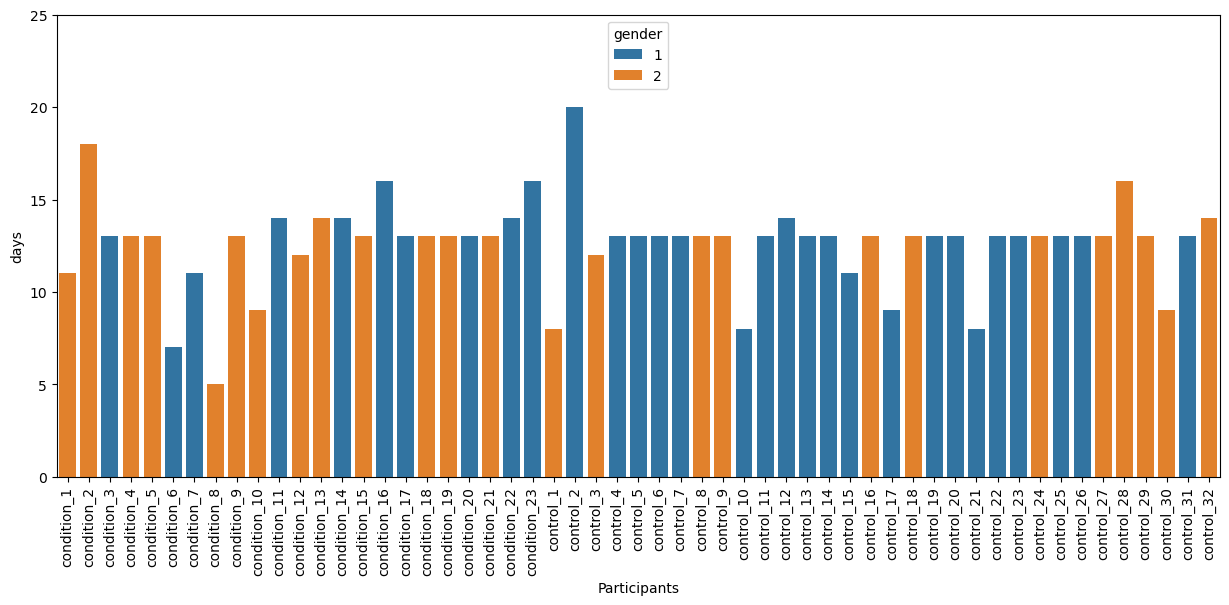

In [31]:
plt.figure(figsize=(15, 6))
sns.barplot(data=scores, x='number', y='days', hue='gender', dodge=False)
plt.xticks(rotation=90)
plt.ylim(0, 25)
plt.xlabel('Participants')
plt.show()

In [35]:
scores.rename(columns={'number':'id'}, inplace=True)
combined_df = pd.merge(df, scores, on='id')

In [127]:
def sampling(data_frame):
    global sample_df
       
    control = data_frame[data_frame['label'] == 0]
    condition = data_frame[data_frame['label'] == 1]
    
    control_male_df = control[control['gender'] == 1]
    control_female_df = control[control['gender'] == 2]
    condition_male_df = condition[condition['gender'] == 1]
    condition_female_df = condition[condition['gender'] == 2]
    
    control_male_list = list(control_male_df['id'].unique())
    control_female_list = list(control_female_df['id'].unique())
    condition_male_list = list(condition_male_df['id'].unique())
    condition_female_list = list(condition_female_df['id'].unique())
    
    control_male_sample = random.sample(control_male_list, k=10)
    control_female_sample = random.sample(control_female_list, k=10)
    condition_male_sample = random.sample(condition_male_list, k=10)
    condition_female_sample = random.sample(condition_female_list, k=10)
    
    
    sample = random.sample(control_male_list, k=10)+random.sample(control_female_list, k=10)+random.sample(condition_male_list, k=10)+random.sample(condition_female_list, k=10)
    
    sample_df = pd.DataFrame()
    
    for participant in sample:
        sample_df = pd.concat([sample_df, data_frame[data_frame['id'] == participant]])
    
    return sample_df
            
sampling(combined_df)

,timestamp,date,activity,id,label,Date,Year,Month,Day,Hour,...,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
305135,2002-10-02 15:00:00,2002-10-02,181,control_2,0,2002-10-02,2002,October,Wednesday,15,...,1,30-34,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
305136,2002-10-02 15:01:00,2002-10-02,76,control_2,0,2002-10-02,2002,October,Wednesday,15,...,1,30-34,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
305137,2002-10-02 15:02:00,2002-10-02,141,control_2,0,2002-10-02,2002,October,Wednesday,15,...,1,30-34,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
305138,2002-10-02 15:03:00,2002-10-02,156,control_2,0,2002-10-02,2002,October,Wednesday,15,...,1,30-34,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
305139,2002-10-02 15:04:00,2002-10-02,32,control_2,0,2002-10-02,2002,October,Wednesday,15,...,1,30-34,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064784,2004-09-15 08:10:00,2004-09-15,0,condition_10,1,2004-09-15,2004,September,Wednesday,8,...,2,45-49,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0
1064785,2004-09-15 08:11:00,2004-09-15,0,condition_10,1,2004-09-15,2004,September,Wednesday,8,...,2,45-49,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0
1064786,2004-09-15 08:12:00,2004-09-15,0,condition_10,1,2004-09-15,2004,September,Wednesday,8,...,2,45-49,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0
1064787,2004-09-15 08:13:00,2004-09-15,915,condition_10,1,2004-09-15,2004,September,Wednesday,8,...,2,45-49,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0
